# Code
## Imports

In [1]:
import os

new_directory_path = "..\\..\\"
os.chdir(new_directory_path)

In [2]:
from src.plot import *
from src.parsers import CocoFreeView
from src.preprocess.simulation import (get_saccade_amp, get_saccade_durations, microsaccades_delta, gen_fixations, saccadic_displacement,
                            gen_gaze,
                            downsampling_with_same_size, downsample)
from src.preprocess.noise import add_gaussian_noise, add_elliptical_gaussian_noise, add_random_center_correlated_radial_noise


In [3]:
# DONE Compute de degrees (16 pixels = 16 degrees)
# DONE Compute Microsaccades Pink Noise
# DONE Compute Saccadic displacement
# DONE Compute WebGazer Noise
# DONE Compute Downsampling
# DONE Validation Test
# TODO FineTune: Add blinks

# Test

## Read Data

In [3]:
data = CocoFreeView()
data.summary()

all stimuli  4317
TRAIN
scanpaths:  37038
stimuli:  3714
min stimuli per subject:  3632
max stimuli per subject:  3714
min subject per stimuli:  9
max subject per stimuli:  10
VALID
scanpaths:  6010
stimuli:  603
min stimuli per subject:  589
max stimuli per subject:  603
min subject per stimuli:  9
max subject per stimuli:  10


## Scanpath

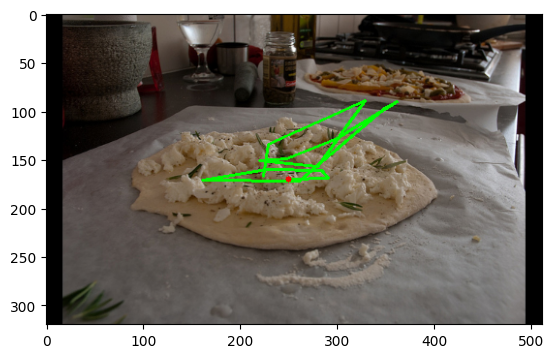

In [5]:
img = data.get_img(0).copy()
x,y,t = data.get_scanpath([0])
draw_scanpath(img,x[0],y[0])
plt.imshow(img)

## Fixation Duration Distribution

Text(0.5, 1.0, 'Fixation Duration Distribution')

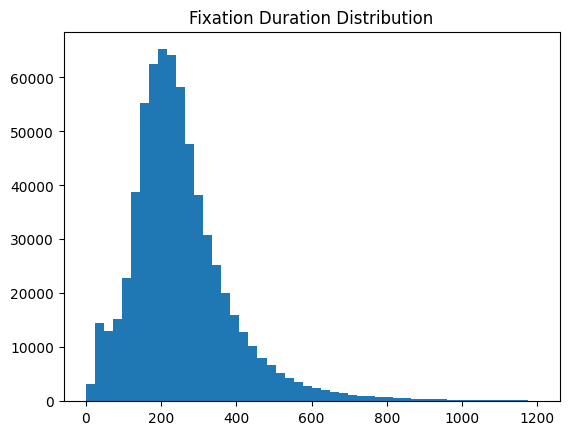

In [7]:
# plot fixation duration distribution
acum = []
for i in range(len(data)):
    x,y,t = data.get_scanpath(i)
    acum += list(t)
acum_cut = [d for d in acum if d < 1200]  # remove outliers
plt.hist(acum_cut, bins=50)
plt.title("Fixation Duration Distribution")

## First Fixation at the center Check

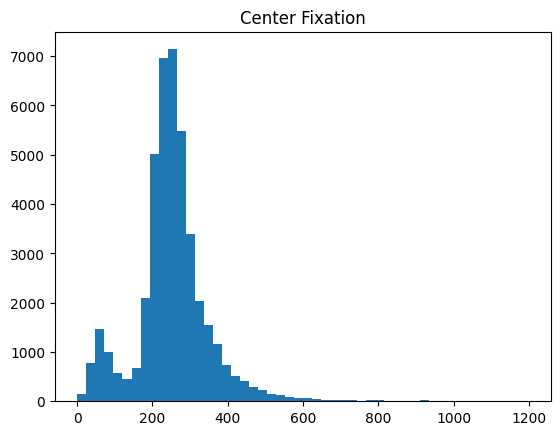

In [10]:
# check center fixation bias
acum_x = []
acum_y = []
acum_d = []
for i in range(len(data)):
    x,y,t = data.get_scanpath(i)
    acum_x.append(x[0])
    acum_y.append(y[0])
    acum_d.append(t[0])



# plt.hist2d(acum_x, acum_y, bins=50,)
# filter longer than 1200ms
acum_d = [d for d in acum_d if d < 1200]
plt.hist(acum_d, bins=50)
plt.title("Center Fixation")
plt.show()

## Computing Saccade Durations

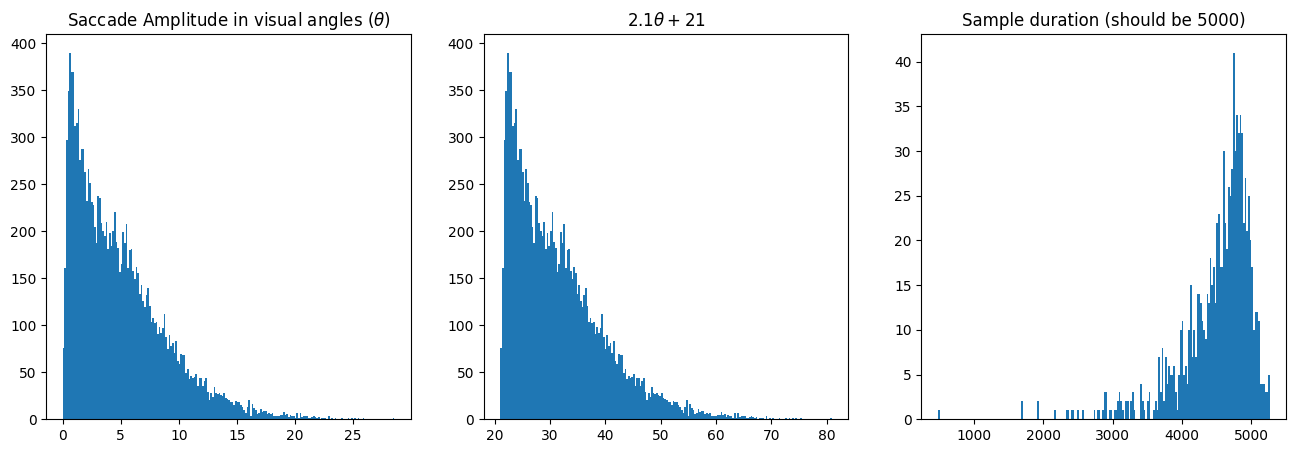

In [6]:
# compute distance
idx= np.random.randint(0, 37038, 1000)
x,y,t = data.get_scanpath(idx)
ang_dist = get_saccade_amp(x,y, data.ptoa)
durations = get_saccade_durations(ang_dist)
all_durations = [sac_dur.sum() + fix_dur.sum() for sac_dur, fix_dur in zip(durations, t)]

fig, axis = plt.subplots(1,3,figsize = (16,5))
axis[0].hist(np.concat(ang_dist),200)
axis[0].set_title(r'Saccade Amplitude in visual angles $(\theta)$')
axis[1].hist(np.concat(durations),200)
axis[1].set_title(r'$2.1 \theta + 21$')
axis[2].hist(all_durations,200)
axis[2].set_title('Sample duration (should be 5000)')
plt.show()


In [13]:
type(x.to_list())
len(x)

1

## Simulate fixations

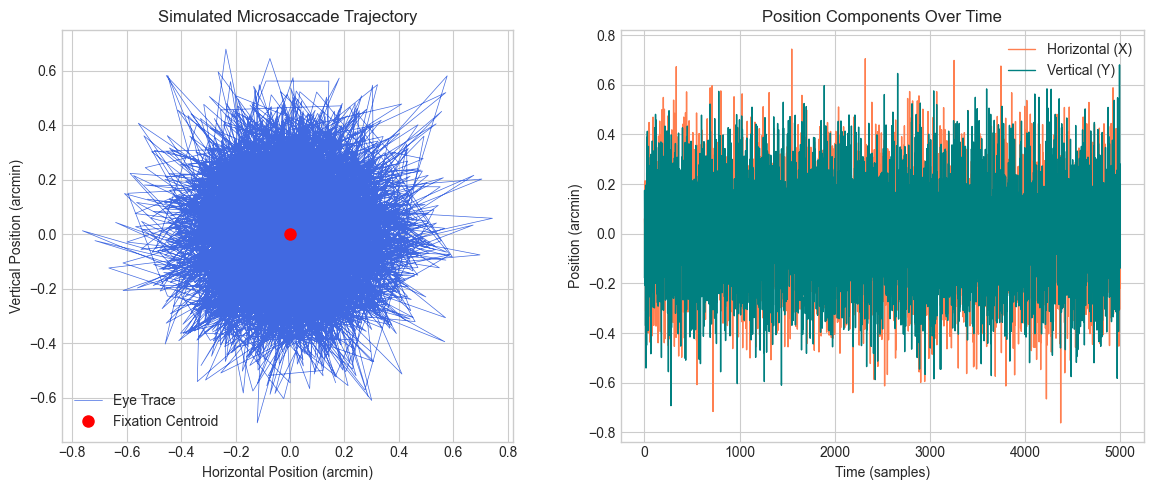

In [7]:
n_samples = 5000 
centroid_x = 0
centroid_y = 0


# Apply the filter to both the X and Y noise signals
microsaccade_x = microsaccades_delta(n_samples)
microsaccade_y = microsaccades_delta(n_samples)

# --- 4. Create the Final Eye Position Trace ---

# The output of the filter is the displacement. Add it to the centroid.
position_x = centroid_x + microsaccade_x
position_y = centroid_y + microsaccade_y

# --- 5. Visualize the Results ---

plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(12, 5))

# Plot 1: 2D Trajectory of Microsaccades
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(position_x, position_y, lw=0.5, color='royalblue', label='Eye Trace')
ax1.plot(centroid_x, centroid_y, 'ro', markersize=8, label='Fixation Centroid')
ax1.set_title('Simulated Microsaccade Trajectory')
ax1.set_xlabel('Horizontal Position (arcmin)')
ax1.set_ylabel('Vertical Position (arcmin)')
ax1.set_aspect('equal', 'box')
ax1.legend()
ax1.grid(True)

# Plot 2: Time Series of X and Y components
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(position_x, lw=1.0, label='Horizontal (X)', color='coral')
ax2.plot(position_y, lw=1.0, label='Vertical (Y)', color='teal')
ax2.set_title('Position Components Over Time')
ax2.set_xlabel('Time (samples)')
ax2.set_ylabel('Position (arcmin)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()



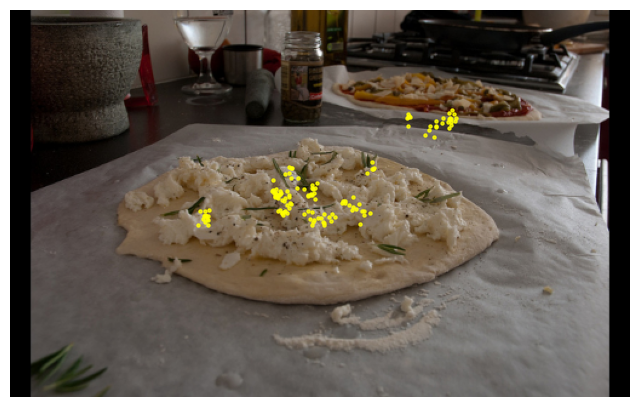

In [8]:
img = data.get_img(0)
x,y,t = data.get_scanpath([0])
fixations = gen_fixations(x.iloc[0],y.iloc[0],t.iloc[0],30,1/16)
plot_xy_on_image(img, fixations, color="yellow")

## Saccades

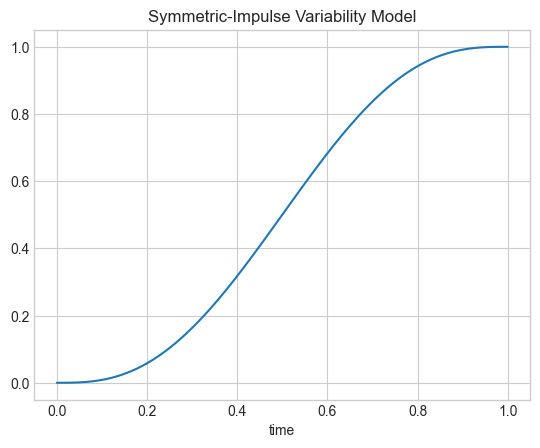

In [9]:
s = np.linspace(0,1,500)
h = saccadic_displacement(s)
plt.title('Symmetric-Impulse Variability Model')
plt.xlabel('time')
plt.plot(s,h)
plt.show()

## Sequencial Generation

In [ ]:
idx = np.random.randint(0, len(data), 3)
clean_gaze = gen_gaze(data, idx, 60)
img_list = [data.get_img(i) for i in idx]
# The ratio from our resolution 1.5*
H, W,_ = img_list[0].shape
cradial_sim_gaze, center = add_random_center_correlated_radial_noise(clean_gaze, [W//2, H//2], (1.5/16),
                                                                     radial_corr = .2,
                                                                     radial_avg_norm= 4.13,
                                                                     radial_std=3.5,
                                                                     center_noise_std=100,
                                                                     center_corr=.3,
                                                                     center_delta_norm=300/1.5,
                                                                     center_delta_r=.3)
gaze_down = downsampling_with_same_size(cradial_sim_gaze, down_time_step=200)

ValueError: too many values to unpack (expected 2)

In [ ]:
(1/16)/3

0.020833333333333332

(320, 512, 3)
(320, 512, 3)
(320, 512, 3)


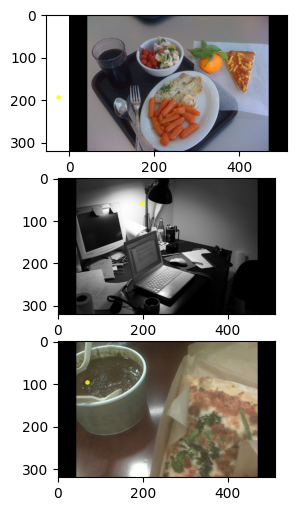

In [ ]:

fig, axis = plt.subplots(3,1, figsize = (18,6))
for i, img in enumerate(img_list):
    print(img.shape)
    axis[i].imshow(img)
    axis[i].scatter(center[0,i], center[1,i], s=5, c='yellow', alpha=.8)


In [ ]:
create_two_gaze_video(gaze_down,clean_gaze,img_list, output_path='output\\video\\vs_scanpath')

✅ Video successfully created at: output\video\vs_scanpath_0.mp4
✅ Video successfully created at: output\video\vs_scanpath_1.mp4
✅ Video successfully created at: output\video\vs_scanpath_2.mp4
